In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from strategy import backtest
from tools import *

def read_data(path, password):
    _df = crp.read_encrypted(path=path, password=password)
    _df = _df.fillna(0)
    _df /= 100  # change to decimal
    
    _df = _df.apply(lambda x : np.where(x > 1, 0, x))
    _df = _df.apply(lambda x : np.where(x < -1, 0, x))
    
    _df['strat_4'] = 0
    _df['strat_5'] = 0
        
    return _df

path = './public_data/'

file_name = 'release_5915.crypt'  # example: release_3547.crypt
password = 'ZAH2rZHDFABdhC5k' 
df = read_data(path=path + file_name, password=password)

new_file_name = 'release_5915.crypt'
new_password = 'ZAH2rZHDFABdhC5k'

In [2]:
ranks = pd.DataFrame()
data = df[-78:].copy()
ranks['Sortino'] = sortino_ratio(data).sort_values(ascending=False)
ranks['Max Drawdown'] = max_drawdown(data).sort_values(ascending=True)
ranks

,Sortino,Max Drawdown
strat_37,13.342191,0.068928
strat_12,12.230591,0.058915
strat_31,10.735544,0.074531
strat_57,9.886568,0.044060
strat_45,8.082707,0.082788
strat_29,7.250760,0.062698
strat_46,5.937185,0.032302
strat_48,5.775964,0.095682
strat_19,5.749707,0.047078
strat_27,3.870044,0.055873


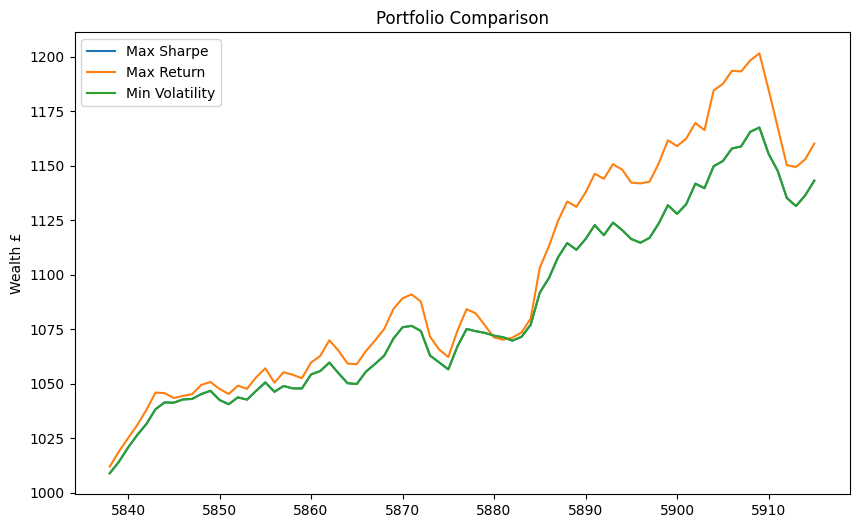

1.0
1.0


In [3]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
portfolio_sharpes = []

def compute_portfolio_return(_df, _weights):
    return (1 + np.sum(_weights * _df.mean())) ** 252 - 1

def compute_portfolio_risk(_df, _weights):  # portfolio variance formula
    return np.sqrt(_weights.T @ (_df.cov() * 252) @ _weights)

def compute_random_portfolio(_df, _iterations) -> None:
    ranks = sortino_ratio(_df).sort_values(ascending=False).index[:24] 
    ranks = [int(strat[6:]) for strat in ranks]
    no_of_stocks = _df.shape[1]
    
    rank_4 = ranks[:4] # top 4
    for i in range(_iterations):
        weights = np.zeros(no_of_stocks)
        for n in range(no_of_stocks):
            if n in rank_4 or n not in ranks:
                weights[n] = 0
            else:
                x = np.random.random()
                if x > 0.1:
                    x /= 2
                weights[n] = x + 0.001
                
        weights = weights.round(4)
        weights /= abs(weights).sum()
        weights *= 0.6
        
        for n in rank_4:
            weights[n] = 0.1
        
        portfolio_weights.append(weights)
        
        expected_return = compute_portfolio_return(_df, weights)
        portfolio_returns.append(expected_return)
        
        risk = compute_portfolio_risk(_df, weights)
        portfolio_risks.append(risk)
        
        sharpe = expected_return / risk
        portfolio_sharpes.append(sharpe)
    
data = df[-78:]

# run the simulations
compute_random_portfolio(data, 10_000)

# get the Max Sharpe Ratio, Max Return, Min Volatility
max_sharpe = max(portfolio_sharpes)
max_return = max(portfolio_returns)
min_risk = min(portfolio_risks)

# find the portfolio index for each
sharpe_idx = portfolio_sharpes.index(max_sharpe)
return_idx = portfolio_returns.index(max_return)
min_risk_idx = portfolio_risks.index(min_risk)

# find the portfolio weights for each
sharpe_w = portfolio_weights[sharpe_idx]
max_return_w = portfolio_weights[return_idx]
min_risk_w = portfolio_weights[min_risk_idx]

INITIAL_CASH = 1_000

def compute_wealth(_df, _weights):
    initial_values = (1 + _df.iloc[0]) * _weights * INITIAL_CASH
    cumulative_ret = np.cumprod(1 + _df)
    cumulative_wealths = cumulative_ret * initial_values
    
    return cumulative_wealths.sum(axis=1)


values = pd.DataFrame()
values['Max Sharpe'] = compute_wealth(data, sharpe_w)
values['Max Return'] = compute_wealth(data, max_return_w)
values['Min Volatility'] = compute_wealth(data, min_risk_w)

plt.figure(figsize=(10, 6))
plt.plot(values['Max Sharpe'], label='Max Sharpe')
plt.plot(values['Max Return'], label='Max Return')
plt.plot(values['Min Volatility'], label='Min Volatility')
plt.title('Portfolio Comparison')
plt.ylabel('Wealth £')
plt.legend()
plt.show()

# find the portfolio weights
results_weights = pd.DataFrame(index=data.columns)
results_weights['max sharpe ratio'] = sharpe_w
results_weights['max return'] = max_return_w
results_weights['min risk'] = min_risk_w 

clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

# clipped_weights
# more = sum(clipped_weights) - 1
# if more != 0:
#     stuff = results_weights['max sharpe ratio'].sort_values(ascending=False)
#     print(stuff)
#     idx = 0
#     if more > 0:
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
#     else: # we are missing stuff
#         more *= -1
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
# clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

In [4]:
pos_dict = clipped_weights.to_dict()
get_submission_dict(pos_dict)

{'strat_0': 0.0,
 'strat_1': 0.0,
 'strat_2': 0.0,
 'strat_3': 0.0,
 'strat_4': 0.0,
 'strat_5': 0.0,
 'strat_6': 0.0,
 'strat_7': 0.011563539239047892,
 'strat_8': 0.008311293828065674,
 'strat_9': 0.0,
 'strat_10': 0.0,
 'strat_11': 0.0,
 'strat_12': 0.1,
 'strat_13': 0.06683599989525779,
 'strat_14': 0.0,
 'strat_15': 0.045735683050092964,
 'strat_16': 0.022247243970776924,
 'strat_17': 0.0,
 'strat_18': 0.0,
 'strat_19': 0.010903663358558748,
 'strat_20': 0.0,
 'strat_21': 0.013480321558563985,
 'strat_22': 0.0035193380292754457,
 'strat_23': 0.0,
 'strat_24': 0.0,
 'strat_25': 0.01567990782686114,
 'strat_26': 0.0,
 'strat_27': 0.03368509256592213,
 'strat_28': 0.0,
 'strat_29': 0.04883081515619682,
 'strat_30': 0.0,
 'strat_31': 0.1,
 'strat_32': 0.06257822933305401,
 'strat_33': 0.04444735395009034,
 'strat_34': 0.0,
 'strat_35': 0.0,
 'strat_36': 0.0,
 'strat_37': 0.1,
 'strat_38': 0.0003613606012202466,
 'strat_39': 0.0,
 'strat_40': 0.0,
 'strat_41': 0.0,
 'strat_42': 0.01308

In [5]:
df1 = read_data(path + new_file_name, new_password)
pnls = pnl(df1[-78:], clipped_weights)

In [6]:
from strategy import *
history = []
backtest(history, get_submission_dict(pos_dict), new_file_name, new_password)

0.13731337821144818


In [7]:
history

[0.004464216267430893,
 0.005130610634865692,
 0.006477800191507112,
 0.005631066317778157,
 0.004912255783043823,
 0.006499938751375202,
 0.0031683884633133923,
 -0.00012379126257674528,
 0.001473569104162268,
 0.00019817799068675248,
 0.0020844392644921547,
 0.0014432744793533693,
 -0.0040200681683105624,
 -0.0018435453918534688,
 0.0029371967141851372,
 -0.0010117506016331984,
 0.003878989640512144,
 0.0036979055888263727,
 -0.0040305588774939725,
 0.002432190662493904,
 -0.0010298386930850663,
 -4.807700457285443e-05,
 0.005993066874149703,
 0.0014145866718511693,
 0.003630742009905398,
 -0.004511163822224384,
 -0.004253847597237236,
 -0.0002604770521004705,
 0.005362064110643127,
 0.00324402115337467,
 0.003410056133742038,
 0.007230101283030089,
 0.004922949707356016,
 0.0005219548145371774,
 -0.002119342887779533,
 -0.010129931257150901,
 -0.00277598866365935,
 -0.0029446395212689405,
 0.00967786172472462,
 0.007282953436188653,
 -0.0008946462936498193,
 -0.0005913588454287902,


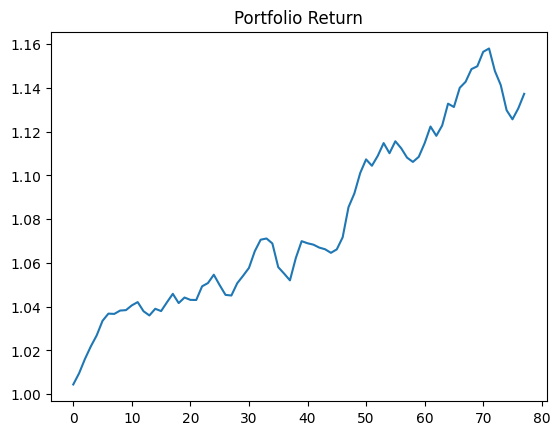

Annual Return:  0.519390209773068
Annual Volatility:  0.07233000110097834
Cumulative Return:  0.13731337821144818


In [8]:
plt.plot(np.cumprod(1 + pnls))
plt.title('Portfolio Return')
plt.show()

sharpe = sharpe_ratio(pnls)
print('Annual Return: ', annual_return(pnls))
print('Annual Volatility: ', annual_risk(pnls))
print('Cumulative Return: ', get_value(pnls)[-1] - 1)

Sharpe:  -0.8616157049344606
Cumulative Return:  -0.011924040177239803


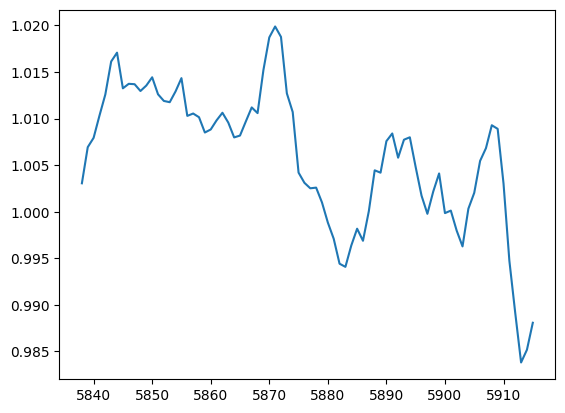

In [9]:
plt.plot(np.cumprod(1 + df1[-78:].mean(axis=1)))
print('Sharpe: ', sharpe_ratio(df1[-78:].mean(axis=1)))
print('Cumulative Return: ', get_value(df1[-78:].mean(axis=1)).iloc[-1] - 1)